## Import statements

In [968]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from itertools import product
from scipy.optimize import minimize
from sklearn.utils import shuffle

## Load captcha images

In [963]:
data = np.load('./preprocessed-data.npz')
X, y, y_labels = data['X'], data['y'], data['y_labels']

In [3]:
X.shape

(1070, 50, 200, 1)

## Create our image generator

In [6]:
generator = ImageDataGenerator(
    width_shift_range=0.1,
    shear_range=0.15,
    rotation_range=7)

In [14]:
it = generator.flow(X[50:400, :, :, :], batch_size=32, shuffle=True)

## Visualize our generated images

In [17]:
batch = next(it)

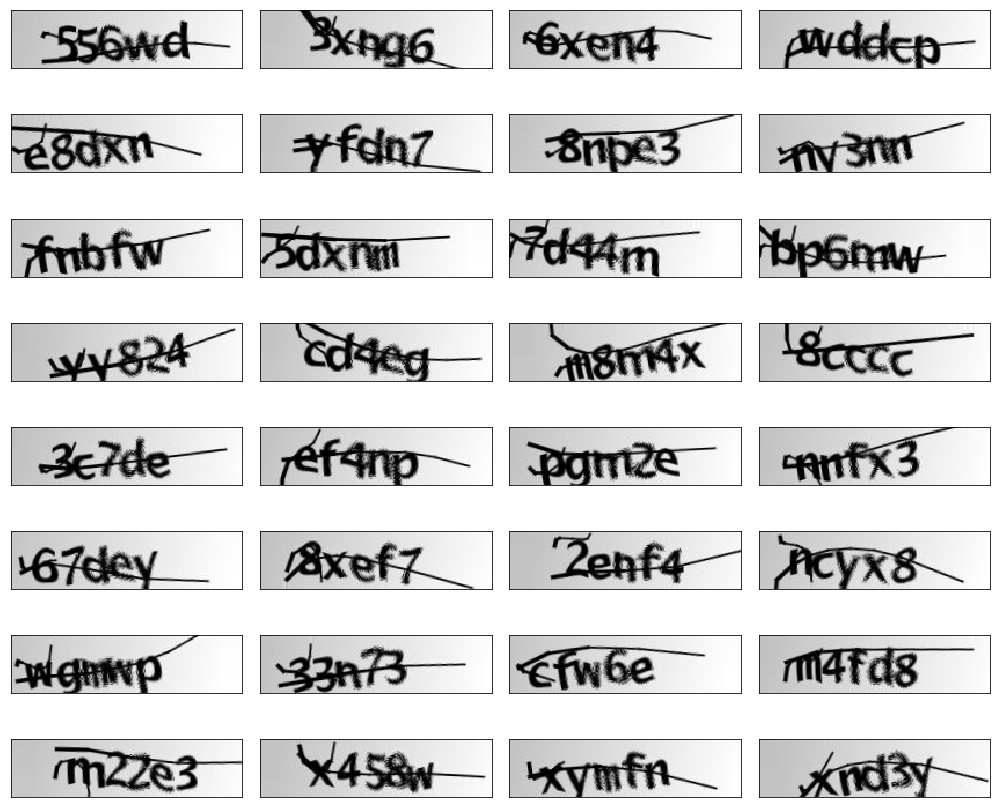

In [18]:
fig, ax = plt.subplots(8, 4, figsize=(14, 12))

for i, j in product(range(0, 8), range(0, 4)):
    plt.sca(ax[i, j])
    plt.imshow(batch[i * 4 + j, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

## Generate data and keep the char frequencies balanced

In [787]:
def normalized(x, bounds=(0, 1)):
    return ((x - x.min()) / (x.max() - x.min())) * bounds[1] + bounds[0]

In [794]:
def clamped(x, bounds=(0, 1)):
    return np.maximum(np.minimum(x, bounds[1]), bounds[0])

In [845]:
char_f = y.sum(axis=1).sum(axis=0)
char_f_nz = char_f[char_f > 0]
char_f = clamped(char_f, (char_f_nz.min(), char_f_nz.max()))
char_f = 1 - np.power(normalized(char_f), 1)
char_f

array([1.        , 0.97666667, 0.88      , 0.90333333, 0.98333333,
       0.87666667, 0.86333333, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.86      , 0.        , 1.        ,
       0.93666667, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.98666667, 0.89666667, 1.        ,
       1.        , 1.        , 1.        , 0.9       , 0.89666667,
       0.83666667, 0.84      , 0.91      , 0.92666667, 0.89333333,
       1.        ])

In [936]:
rankings = normalized(np.multiply(y, char_f.reshape(1, 1, -1)).sum(axis=2).sum(axis=1))

In [937]:
rankings = normalized(np.add(rankings, ((np.random.random([n]) * 2) - 1) / 18))

In [938]:
increase_size = 8
n = y.shape[0]

def f(x):
    return (x * rankings.sum() - increase_size * n)

def loss(x):
    return f(x) ** 2

def loss_derivative(x):
    return 2 * f(x) * rankings.sum()

In [939]:
result = minimize(loss,
                  x0=np.ones([1]),
                  jac=loss_derivative)

In [940]:
result

      fun: 0.0
 hess_inv: array([[8.00720742e-07]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([10.83251507])

In [978]:
num_repetitions = np.ceil(result.x * rankings).astype(np.uint32)

In [979]:
num_repetitions.sum()

9083

In [980]:
batch_size = 32
num_repetitions[0:(batch_size - int(num_repetitions.sum()) % batch_size)] += 1

In [981]:
num_repetitions.sum()

9088

In [982]:
indices = []
for i in range(0, n):
    indices.extend([i] * num_repetitions[i])
indices = np.array(indices, dtype=np.uint32)

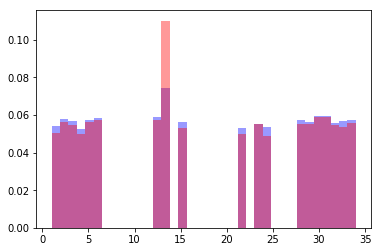

In [983]:
y2 = y[indices, :]
plt.hist(y2.argmax(axis=2).flatten(), bins=36, alpha=0.4, color='blue', density=True);
plt.hist(y.argmax(axis=2).flatten(), bins=36, alpha=0.4, color='red', density=True);

In [984]:
def batch_iterator():
    shuffled_indices = shuffle(indices)
    for index in range(0, n, batch_size):
        batch_indices = shuffled_indices[index:index+batch_size]
        yield from generator.flow(X[batch_indices, :, :, :], y[batch_indices, :, :], batch_size=batch_size, shuffle=False)

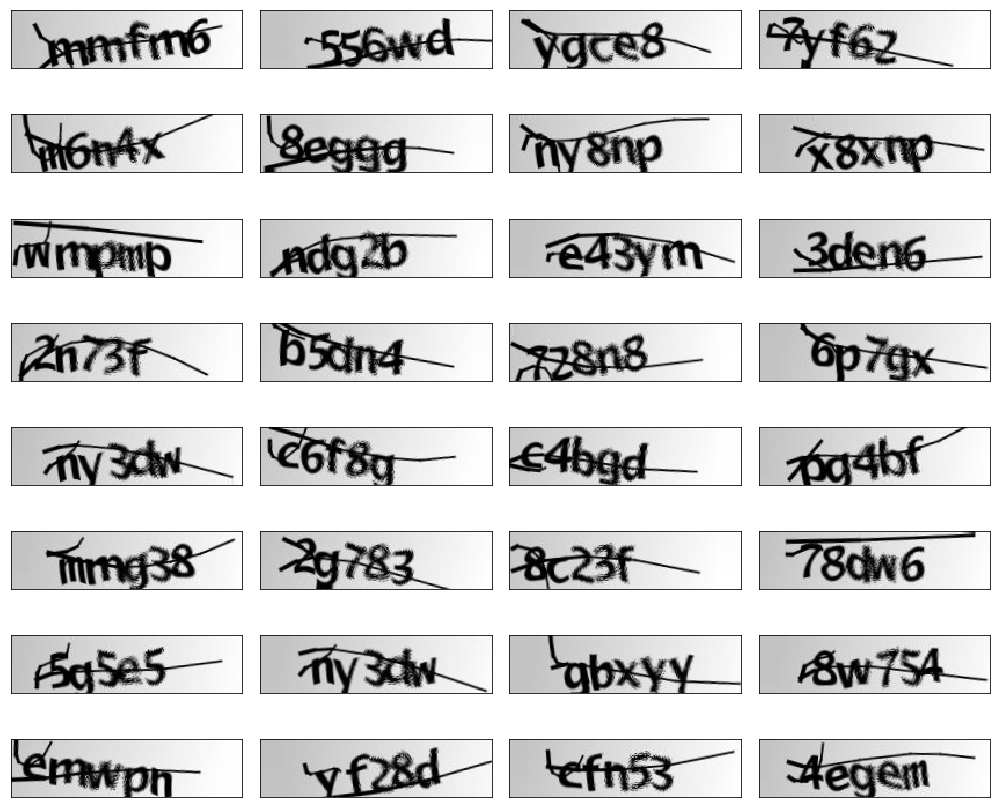

In [988]:
X_batch, y_batch = next(batch_iterator())

fig, ax = plt.subplots(batch_size//4, 4, figsize=(14, 12))

for i, j in product(range(0, batch_size//4), range(0, 4)):
    plt.sca(ax[i, j])
    plt.imshow(X_batch[i * 4 + j, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()